# Imports

In [ ]:
import pandas as pd
import json
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from collections import defaultdict
from array import array
import math
import numpy as np
from numpy import linalg as la
import collections

from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Read documents

In [ ]:
!git clone https://github.com/ialexmp/IRWA.git

Cloning into 'IRWA'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 88 (delta 35), reused 5 (delta 0), pack-reused 0
Receiving objects: 100% (88/88), 3.73 MiB | 13.16 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [ ]:
%cd IRWA/data/

/content/IRWA/data


In [ ]:
evaluation_gt = pd.read_csv("Evaluation_gt.csv")
tweet_document_ids_map = pd.read_csv("Rus_Ukr_war_data_ids.csv", sep="\t", names=["doc", "tweet_id"])
rus_ukr_war_data = []
with open("Rus_Ukr_war_data.json") as f:
  for line in f:
   json_object = json.loads(line)
   rus_ukr_war_data.append(json_object)

In [ ]:
print("Total number of tweets related to the Russo-Ukrainian War: {}".format(len(rus_ukr_war_data)))

Total number of tweets related to the Russo-Ukrainian War: 4000


# Part 1

## **1. Pre-process**


* Removing stop words
* Tokenization
* Removing punctuation marks
* Stemming
* Anything else needed **(bonus point)**




In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stemmer = nltk.stem.SnowballStemmer('english')
custom_stopwords = set(stopwords.words('english'))

In [ ]:
#preprocess function to include stopword removal, tokenization, punctiation marls removal, stemming, newline characters removal and extra whitespaces removal
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove newline characters
    text = text.replace('\\n', '')
    # Remove extra whitespaces
    text = ' '.join(text.split())
    # Delete URLs on the tweet because we won't be able to access to them
    text = re.sub(r'\S*https?:\S*', '', text)
    # Remove spaces at first and at the end of a message
    text.strip()
    # Remove punctuation
    text = re.sub(r'[^a-z0-9#@ ]+', '', text)
    # Tokenize the text
    words = text.split()
    # Remove stopwords and apply stemming
    processed_words = [stemmer.stem(word) for word in words if word not in custom_stopwords]
    return ' '.join(processed_words)

In [ ]:
def preprocess_date(text):
  # Convert date to dd/mm/yyyy
  return pd.to_datetime(datetime.strptime(text, "%a %b %d %H:%M:%S %z %Y").strftime("%d/%m/%Y"), format='%d/%m/%Y')

In [ ]:
processed_data = []
tweet_ids = []
data_df = pd.DataFrame(columns=['Tweet', 'Date', 'Hashtags', 'Likes', 'Retweets', 'Url'])
for line in rus_ukr_war_data:
    processed_text = preprocess(line["full_text"])
    hashtags_list = [preprocess(hashtag["text"]) for hashtag in line["entities"]["hashtags"]]
    hashtags = ', '.join(hashtags_list)
    tweet_id = line["id_str"]
    tweet_ids.append(tweet_id)
    user = line["user"]["screen_name"]
    url = f"https://twitter.com/{user}/status/{tweet_id}"
    date = preprocess_date(line["created_at"])
    processed_data.append(processed_text + '|' + str(date) + '|' + str(len(hashtags.split(", "))) + '|' + str(line["favorite_count"]) + '|' + str(line["retweet_count"]) + '|' + url)
    data_df.loc[len(data_df)] = {"Tweet": processed_text, "Date": date, "Hashtags": len(hashtags.split(", ")), "Likes": line["favorite_count"], "Retweets": line["retweet_count"], "Url": url}

In [ ]:
print(processed_data[7])
data_df.head(8)

#ukrainerussiawar #ukrain #russia #osc condemn russia illeg annex ukrainian territori call russian feder withdraw forc across ukrain|2022-09-30 00:00:00|4|0|0|https://twitter.com/EUFreeCitizen/status/1575917748978434053


,Tweet,Date,Hashtags,Likes,Retweets,Url
0,@melsimmonsfcdo wrong dictat putin fascist rus...,2022-09-30,2,0,0,https://twitter.com/LynBank25442089/status/157...
1,arm forc liber villag #drobyshev #lymansk urba...,2022-09-30,12,0,0,https://twitter.com/Feher_Junior/status/157591...
2,alert poland prep antiradi tablet nuclear thre...,2022-09-30,6,0,0,https://twitter.com/NEWS_ALL_TIME/status/15759...
3,im still wait googl map updat russia new annex...,2022-09-30,2,0,0,https://twitter.com/Magzprestige/status/157591...
4,@emmanuelmacron probabl your right say anyway ...,2022-09-30,2,0,0,https://twitter.com/t3zx9kc7rs1/status/1575917...
5,estonia lithuania latvia fulli support welcom ...,2022-09-30,4,0,0,https://twitter.com/NEWS_ALL_TIME/status/15759...
6,nato ukrain poke bear russia get mad bear russ...,2022-09-30,4,0,0,https://twitter.com/A0zeir/status/157591775136...
7,#ukrainerussiawar #ukrain #russia #osc condemn...,2022-09-30,4,0,0,https://twitter.com/EUFreeCitizen/status/15759...


## **2. Exploratory Data Analysis**

### Tweet

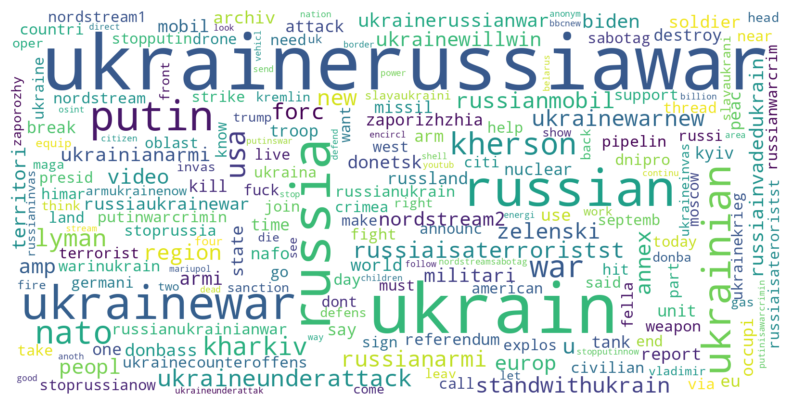

In [ ]:
# Word Cloud
all_tweets = ' '.join(data_df['Tweet'])
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate(all_tweets) #Collocations = False to avoid bigrams.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#Most Mentioned User Analysis
data_df["mentions"] = data_df["Tweet"].str.findall(r'@(\w+)')
users = data_df.explode("mentions")["mentions"].value_counts()
print(users[:10])

zelenskyyua    44
youtub         40
potus          31
mfarussia      22
eucommiss      22
russiaun       21
ukrain         20
nato           20
defenceu       19
cnn            12
Name: mentions, dtype: int64


### Date

In [ ]:
# There is some tweet about the war before it started?
data_df[data_df["Date"] <= pd.to_datetime('2020-02-24')]

,Tweet,Date,Hashtags,Likes,Retweets,Url,mentions


### Hashtags



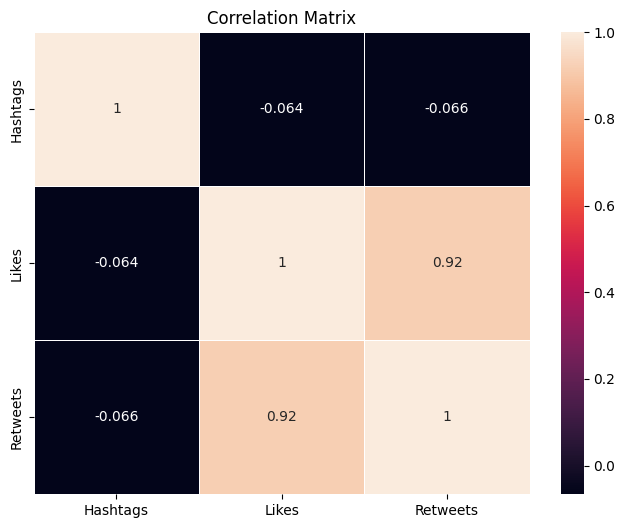

In [ ]:
# Correlation Matrix
data_corr = data_df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(data_corr, annot=True, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

### Likes

In [ ]:
# Descriptive Statistics about the likes
data_df["Likes"].describe()

count    4000.000000
mean       11.436250
std       100.265304
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max      3701.000000
Name: Likes, dtype: float64

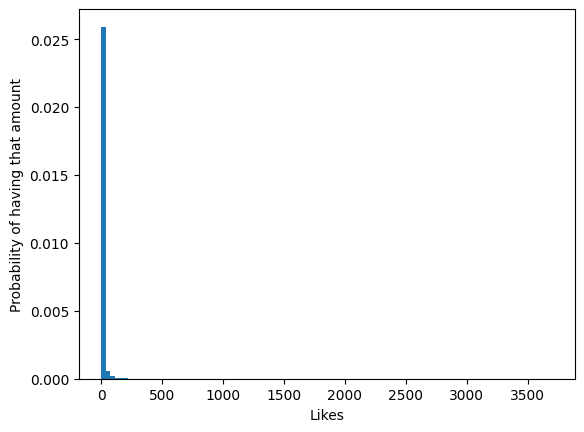

In [ ]:
# Histogram about the Likes and their probability
likes = data_df["Likes"]
plt.hist(likes, bins=100, density=True)
plt.xlabel("Likes")
plt.ylabel("Probability of having that amount")
plt.show()

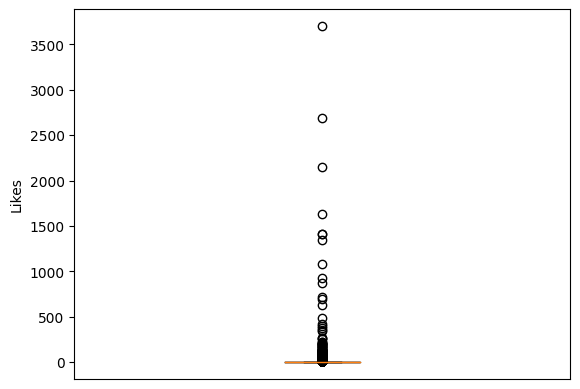

In [ ]:
# Boxplot Likes
plt.boxplot(likes)
plt.ylabel("Likes")
plt.gca().set_xticks([])
plt.show()

In [ ]:
# Top 10 most liked tweets
viral_tweets = data_df.sort_values("Likes", ascending = False)
viral_tweets.head(10)

,Tweet,Date,Hashtags,Likes,Retweets,Url,mentions
1219,situat around lyman sep 30 1100 ua forc liber ...,2022-09-30,1,3701,646,https://twitter.com/Militarylandnet/status/157...,[]
2813,uniqu rare photo ukrainian forward command pos...,2022-09-29,2,2685,338,https://twitter.com/Militarylandnet/status/157...,[]
3765,oper interflex ukrainian recruit continu maste...,2022-09-28,1,2155,283,https://twitter.com/Militarylandnet/status/157...,[]
2823,czech volunt ongo offens ukrainian forc #khark...,2022-09-29,2,1631,114,https://twitter.com/Militarylandnet/status/157...,[]
205,ukrainian forc liber drobyshev #donetsk oblast...,2022-09-30,2,1407,171,https://twitter.com/Militarylandnet/status/157...,[]
2118,kostyantyn nemichev command kraken special uni...,2022-09-29,1,1407,136,https://twitter.com/Militarylandnet/status/157...,[]
3801,ukrainian paratroop btr3 offens #kharkiv#donet...,2022-09-28,3,1348,133,https://twitter.com/Militarylandnet/status/157...,[]
450,zelenski announc ukrain submit acceler applic ...,2022-09-30,1,1083,96,https://twitter.com/Militarylandnet/status/157...,[]
1846,follow countri urg citizen leav updat govern m...,2022-09-29,3,923,251,https://twitter.com/OSINTschizo/status/1575625...,[]
1244,ukrainian forc liber yampil #donetsk oblast #u...,2022-09-30,2,868,69,https://twitter.com/Militarylandnet/status/157...,[]


### Retweets

In [ ]:
# Descriptive Statistics about the retweets
data_df["Retweets"].describe()

count    4000.000000
mean        2.123000
std        15.828361
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       646.000000
Name: Retweets, dtype: float64

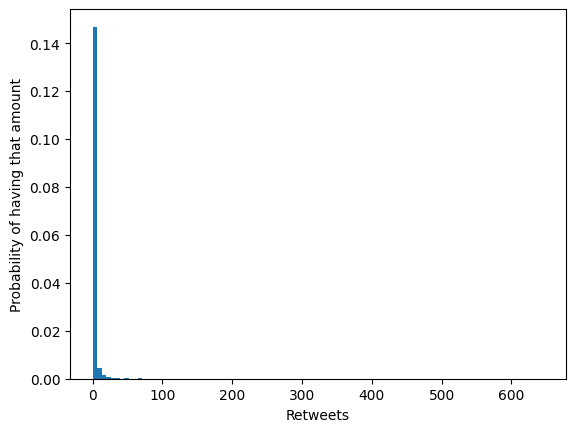

In [ ]:
# Histogram about the Retweets and their probability
retweets = data_df["Retweets"]
plt.hist(retweets, bins=100, density=True)
plt.xlabel("Retweets")
plt.ylabel("Probability of having that amount")
plt.show()

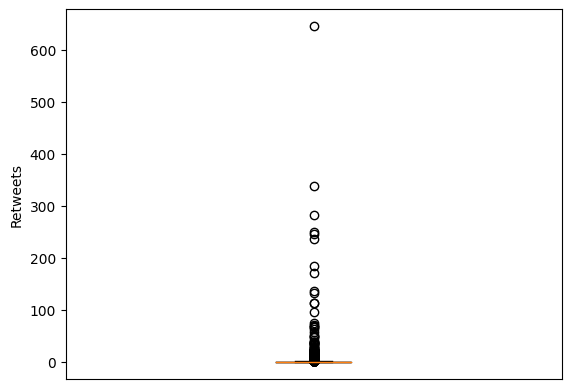

In [ ]:
# Boxplot Likes
plt.boxplot(retweets)
plt.ylabel("Retweets")
plt.gca().set_xticks([])
plt.show()

In [ ]:
# Top 10 most retweeted tweets
most_retweeted_tweets = data_df.sort_values("Retweets", ascending = False)
most_retweeted_tweets.head(10)

,Tweet,Date,Hashtags,Likes,Retweets,Url,mentions
1219,situat around lyman sep 30 1100 ua forc liber ...,2022-09-30,1,3701,646,https://twitter.com/Militarylandnet/status/157...,[]
2813,uniqu rare photo ukrainian forward command pos...,2022-09-29,2,2685,338,https://twitter.com/Militarylandnet/status/157...,[]
3765,oper interflex ukrainian recruit continu maste...,2022-09-28,1,2155,283,https://twitter.com/Militarylandnet/status/157...,[]
1846,follow countri urg citizen leav updat govern m...,2022-09-29,3,923,251,https://twitter.com/OSINTschizo/status/1575625...,[]
1387,russian shell outskirt #zaporizhzhia hit civil...,2022-09-30,2,694,247,https://twitter.com/Militarylandnet/status/157...,[]
1209,war end call annex referendum genuin express p...,2022-09-30,3,270,236,https://twitter.com/CyberMartiansio/status/157...,[]
1532,russia may drop 11 meter long x22 missil weigh...,2022-09-30,4,713,184,https://twitter.com/Ukraine66251776/status/157...,[]
205,ukrainian forc liber drobyshev #donetsk oblast...,2022-09-30,2,1407,171,https://twitter.com/Militarylandnet/status/157...,[]
2118,kostyantyn nemichev command kraken special uni...,2022-09-29,1,1407,136,https://twitter.com/Militarylandnet/status/157...,[]
3801,ukrainian paratroop btr3 offens #kharkiv#donet...,2022-09-28,3,1348,133,https://twitter.com/Militarylandnet/status/157...,[]


In [ ]:
# How many tweets contain the word rt or retweet?
contains_rt = data_df["Tweet"].str.contains(r'\brt\b|retweet')
data_contains_rt = data_df[contains_rt].sort_values("Retweets", ascending = False)
print("Head:")
display(data_contains_rt.head())
print("\nTail:")
display(data_contains_rt.tail())

Head:


,Tweet,Date,Hashtags,Likes,Retweets,Url,mentions
2981,attent maximum retweet help bring back brother...,2022-09-29,2,3,3,https://twitter.com/PK2451167992/status/157535...,[]
3006,much go world right #ai #art simpli send love ...,2022-09-29,10,5,2,https://twitter.com/YnobeCrypto/status/1575344...,[]
3502,retweet regular occasion tweet #ukrainerussiaw...,2022-09-28,1,11,2,https://twitter.com/B1EMW/status/1575211708829...,[nickreeves9876]
1105,bomber biden strangl life europ retweet agre #...,2022-09-30,5,2,1,https://twitter.com/Socialism4life/status/1575...,[]
1485,follow real time announc peopl report locat uk...,2022-09-30,3,0,0,https://twitter.com/UkraineOnGround/status/157...,[]



Tail:


,Tweet,Date,Hashtags,Likes,Retweets,Url,mentions
1105,bomber biden strangl life europ retweet agre #...,2022-09-30,5,2,1,https://twitter.com/Socialism4life/status/1575...,[]
1485,follow real time announc peopl report locat uk...,2022-09-30,3,0,0,https://twitter.com/UkraineOnGround/status/157...,[]
1625,follow real time inform peopl report present u...,2022-09-30,3,1,0,https://twitter.com/UkraineOnGround/status/157...,[]
3303,@kyivindepend everyon honest free world retwee...,2022-09-28,5,1,0,https://twitter.com/ingold_we/status/157524809...,[kyivindepend]
3499,former everton midfield diniyar bilyaletdinov ...,2022-09-28,2,2,0,https://twitter.com/KorrectSports/status/15752...,[]


# Part 2

In [ ]:
def preprocess2(text):
  # Remove @ and # in order to do the indexing
  text = re.sub(r'[^a-z0-9 ]+', '', text)
  return text

data_df["Tweet"] = data_df["Tweet"].apply(preprocess2)
data_df.head(8)

,Tweet,Date,Hashtags,Likes,Retweets,Url,mentions
0,melsimmonsfcdo wrong dictat putin fascist russ...,2022-09-30,2,0,0,https://twitter.com/LynBank25442089/status/157...,[melsimmonsfcdo]
1,arm forc liber villag drobyshev lymansk urban ...,2022-09-30,12,0,0,https://twitter.com/Feher_Junior/status/157591...,[]
2,alert poland prep antiradi tablet nuclear thre...,2022-09-30,6,0,0,https://twitter.com/NEWS_ALL_TIME/status/15759...,[]
3,im still wait googl map updat russia new annex...,2022-09-30,2,0,0,https://twitter.com/Magzprestige/status/157591...,[]
4,emmanuelmacron probabl your right say anyway g...,2022-09-30,2,0,0,https://twitter.com/t3zx9kc7rs1/status/1575917...,[emmanuelmacron]
5,estonia lithuania latvia fulli support welcom ...,2022-09-30,4,0,0,https://twitter.com/NEWS_ALL_TIME/status/15759...,[]
6,nato ukrain poke bear russia get mad bear russ...,2022-09-30,4,0,0,https://twitter.com/A0zeir/status/157591775136...,[]
7,ukrainerussiawar ukrain russia osc condemn rus...,2022-09-30,4,0,0,https://twitter.com/EUFreeCitizen/status/15759...,[]


In [ ]:
# We mix both dataframes in one
data_df["tweet_id"] = data_df["Url"].apply(lambda x: x.split("/")[5]).astype(int)
result_df = tweet_document_ids_map.merge(data_df, on='tweet_id', how='inner')
data_df = data_df.drop('tweet_id', axis=1)
result_df = result_df.drop('tweet_id', axis=1)

## Indexing

### Build inverted index

In [ ]:
def create_index(df):
    """
    Implement the inverted index

    Argument:
    lines -- collection of tweets

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """

    index = defaultdict(list)
    url_lines = {}  # dictionary to map the line to url

    for i, line in df.iterrows():
        doc_id = line["doc"]
        full_tweet = line["Tweet"]
        url_lines[doc_id] = line["Url"]

        tweet_index = {}

        for position, tweet in enumerate(full_tweet.split(" ")): # terms contains the query
            try:
                # if the term is already in the index for the tweet index (tweet_index)
                # append the position to the corresponding list
                tweet_index[tweet][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                tweet_index[tweet]=[doc_id, array('I',[position])]         #'I' indicates unsigned int (int in Python)

        #merge the row and the position
        for row, position in tweet_index.items():
            index[row].append(position)

    return index, url_lines

In [ ]:
def search(query, index):
    """
    The output is the list of tweets in documents that contain any of the query terms.
    So, we will get the list of tweets in documents for each query term, and take the union of them.
    """

    query = preprocess(query)
    tweets = set()

    for each_query in query.split(" "):
        try:
            # store in query_tweet the ids of the tweets (the rows) that contain "each_query"
            query_tweet=[posting[0] for posting in index[each_query]]
            tweets = tweets.union(query_tweet)
        except:
            #term is not in index
            pass
    tweets = list(tweets)
    return tweets

### Propose test queries

In [ ]:
index, url_lines = create_index(result_df)

# Keywords from WordCloud: ukrain, ukrainerussiawar, nato, putin, war, dnipro, stopputin, russiaisaterrorist, zelenski, kherson, lyman
queries = ["Russian intervention Ukraine", "NATO Ukraine", "Dnipro war", "Zelenski leadership Ukraine war", "Stop Putin's aggression Ukraine"]

self_queries_dt = {}
for i, query in enumerate(queries):
  self_queries_dt[f'Q{i+1}'] = {"name": query, "query_id": f'Q{i+1}'}

### Rank your results

In [ ]:
def create_index_tfidf(dataframe, num_tweets):
    """
    Implement the inverted index and compute tf, df and idf

    Argument:
    dataframe -- collection of tweets
    num_tweets -- total number of tweets

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document/tweet these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each documents/tweets
    df - number of documents/tweets each term appear in
    idf - inverse document/tweet frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  # tweet frequencies of full_tweet in tweets (tweets in the same order as in the main index)
    df = defaultdict(int)  # tweet frequencies of full_tweet in the corpus
    url_lines = defaultdict(str)
    idf = defaultdict(float)

    for i, line in dataframe.iterrows():
        doc_id = line["doc"]
        full_tweet = line["Tweet"]
        url_lines[doc_id] = line["Url"]

        tweet_index = {}

        for position, tweet in enumerate(full_tweet.split(" ")):
            try:
                # if the tweet is already in the dict append the position to the corresponding list
                tweet_index[tweet][1].append(position)
            except:
                # Add the new tweet as dict key and initialize the array of positions and add the position
                tweet_index[tweet]=[doc_id, array('I',[position])] #'I' indicates unsigned int (int in Python)

        # normalize tweet frequencies
        # Compute the denominator to normalize tweet frequencies
        # norm is the same for all full_tweet of a tweet.
        norm = 0
        for tweet, posting in tweet_index.items():
            # posting ==> [current_tweet, [list of positions]]
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        # calculate the tf(dividing the tweet frequency by the above computed norm) and df weights
        for tweet, posting in tweet_index.items():
            # append the tf for current tweet (tf = tweet frequency in current tweet/norm)
            tf[tweet].append(np.round(len(posting[1])/norm,4))
            #increment the tweet frequency of current tweet (number of tweets containing the current query)
            df[tweet] += 1 # increment DF for current tweet

        #merge the current page index with the main index
        for doc, position in tweet_index.items():
            index[doc].append(position)

        # Compute IDF:
        for term in df:
            idf[term] = np.round(np.log(float(num_tweets/df[term])), 4)

    return index, tf, df, idf, url_lines

In [ ]:
num_tweets = len(result_df)
index, tf, df, idf, url_lines = create_index_tfidf(result_df, num_tweets)

In [ ]:
def rank_tweets(terms, tweets, index, idf, tf, url_lines):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    tweets -- list of the tweets, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document/tweet frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked tweets
    """

    terms = terms.split(" ")

    # I'm interested only on the element of the tweetVector corresponding to the query terms
    # The remaining elements would became 0 when multiplied to the query_vector
    tweet_vectors = defaultdict(lambda: [0] * len(terms))       # Call tweet_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with tweets)
        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term]
        # Generate tweet_vectors for matching tweets
        for row_tweet, (tweet, postings) in enumerate(index[term]):
            if tweet in tweets:
                tweet_vectors[tweet][termIndex] = tf[term][row_tweet] * idf[term]

    # Calculate the score of each tweet
    # compute the cosine similarity between queryVector and each tweetVector:
    tweet_scores=[[np.dot(curTweetVec, query_vector), tweet] for tweet, curTweetVec in tweet_vectors.items() ]
    tweet_scores.sort(reverse=True)
    result_tweets = [x[1] for x in tweet_scores]

    if len(result_tweets) == 0:
        print("No results found, try again")

    return result_tweets

In [ ]:
def search_tf_idf(query, index):
    """
    The output is the list of documents/tweets that contain any of the query terms.
    So, we will get the list of documents/tweets for each query term, and take the union of them.
    """

    query = preprocess(query)
    tweets = set()

    for each_query in query.split(" "):
        try:
            # store in query_tweet the ids of the tweets (the rows) that contain "each_query"
            query_tweet=[posting[0] for posting in index[each_query]]
            tweets = tweets.union(query_tweet)
        except:
            #term is not in index
            pass
    tweets = list(tweets)

    ranked_tweets = rank_tweets(query, tweets, index, idf, tf, url_lines)

    return ranked_tweets

In [ ]:
top = 10
docs = {}
for i, query in enumerate(queries):
  ranked_tweets = search_tf_idf(query, index)
  print("Top {} results out of {} for the searched query: {}\n".format(top, len(ranked_tweets), query))
  for j, doc in enumerate(ranked_tweets[:top]):
      docs[f'Q{i}_{j}'] = {'query': query, 'doc': doc}
      print("doc_id= {} - url_tweet: {}".format(doc, url_lines[doc]))
  print("\n======================\n")

Top 10 results out of 2894 for the searched query: Russian intervention Ukraine

doc_id= doc_1984 - url_tweet: https://twitter.com/InGlore070/status/1575597493508710401
doc_id= doc_3216 - url_tweet: https://twitter.com/InGlore070/status/1575271464021987332
doc_id= doc_347 - url_tweet: https://twitter.com/infussambas/status/1575872044075724802
doc_id= doc_3530 - url_tweet: https://twitter.com/ActForUA/status/1575207467390488576
doc_id= doc_3944 - url_tweet: https://twitter.com/danish_greek/status/1575160028402954240
doc_id= doc_934 - url_tweet: https://twitter.com/gulftoday/status/1575809946251239424
doc_id= doc_3027 - url_tweet: https://twitter.com/infussambas/status/1575339603212771328
doc_id= doc_2770 - url_tweet: https://twitter.com/infussambas/status/1575409000925261824
doc_id= doc_1334 - url_tweet: https://twitter.com/infussambas/status/1575754204249194497
doc_id= doc_1404 - url_tweet: https://twitter.com/infussambas/status/1575734900178956288


Top 10 results out of 2670 for the 

## Evaluation

### Evaluation components

#### Using a subset of the dataset

In [ ]:
queries_dt = {}
queries_dt["Q1"] = "Kharkiv tank"
queries_dt["Q2"] = "Nord Stream pipeline"
queries_dt["Q3"] = "Russia Annexation territories"

for current_query in ["Q1", "Q2", "Q3"]:
    Qevaluation = evaluation_gt[(evaluation_gt['query_id'] == current_query)]
    ranked_tweets = search_tf_idf(queries_dt[current_query], index)
    well_predicted = Qevaluation[(Qevaluation['label']==1)]['doc'].isin(ranked_tweets[:10])
    bad_predicted = Qevaluation[(Qevaluation['label']==0)]['doc'].isin(ranked_tweets[:10])
    print("Docs that we obtained with {} and are truly relevant: {}. Those that are not relevant: {}".format(current_query, well_predicted.sum(), bad_predicted.sum()))

Docs that we obtained with Q1 and are truly relevant: 2. Those that are not relevant: 0
Docs that we obtained with Q2 and are truly relevant: 5. Those that are not relevant: 0
Docs that we obtained with Q3 and are truly relevant: 1. Those that are not relevant: 0


#### Being the expert judges

In [ ]:
import pandas as pd

relevance_self_queries_list = [0] * 5
relevance_self_queries_list[0] = [1, 0, 0, 1, 0, 1, 1, 0, 1, 1]
relevance_self_queries_list[1] = [1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
relevance_self_queries_list[2] = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
relevance_self_queries_list[3] = [0, 0, 0, 1, 1, 1, 1, 1, 0, 1]
relevance_self_queries_list[4] = [1, 0, 1, 1, 0, 0, 1, 1, 1, 1]

dfs = []

for i, list_ in enumerate(relevance_self_queries_list):
    for j, label in enumerate(list_):
        df = pd.DataFrame({'doc': docs[f'Q{i}_{j}']['doc'], 'query_id': f'Q{i+1}', 'label': label}, index=[0])
        dfs.append(df)

relevance_self_queries = pd.concat(dfs, ignore_index=True)

display(relevance_self_queries)

,doc,query_id,label
0,doc_1984,Q1,1
1,doc_3216,Q1,0
2,doc_347,Q1,0
3,doc_3530,Q1,1
4,doc_3944,Q1,0
5,doc_934,Q1,1
6,doc_3027,Q1,1
7,doc_2770,Q1,0
8,doc_1334,Q1,1
9,doc_1404,Q1,1


### Prior evaluation components

In [ ]:
def precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order)
    relevant = np.sum(doc_score[:k]) / k
    return np.round(relevant, 4)

In [ ]:
def recall_at_k(doc_score, y_score, k=10):
    order = y_score.argsort()[::k]
    doc_score = np.take(doc_score, order)
    relevant = np.sum(doc_score[:k])
    total_relevant = np.sum(doc_score[:])
    if total_relevant != 0:
      return np.round(float(relevant/total_relevant), 4)
    else:
      return float(0)

In [ ]:
def avg_precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score)
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i+1)
    return np.round((1/gtp) * prec_at_i, 4)

In [ ]:
def f1_score(precision, recall):
  return np.round((2 * precision * recall) / (precision + recall), 4)

In [ ]:
def map_at_k(search_res, k=10):
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        doc_score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res["query_id"].unique():  # loop over all query id
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["label"]), np.array(curr_data["doc"]), k))  #append average precision for current query
    return np.round(np.mean(avp), 4), avp   # return mean average precision

In [ ]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for current query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score and take first k.
    if np.sum(doc_score) == 0:  # if there are not relevant document return 0
        return 0
    return np.round(1/(np.argmax(doc_score) + 1), 4)


In [ ]:
def dcg_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score and take first k.

    gain = 2**doc_score - 1  # Compute gain
    discounts = np.log2(np.arange(2, k + 2))  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k) # Ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score,y_score,k)/dcg_max, 4) # return ndcg@k

In [ ]:
k = 10

for current_query in ["Q1", "Q2", "Q3"]:
  query = evaluation_gt[evaluation_gt["query_id"] == current_query]
  precision = precision_at_k(query["label"], query["doc"], k)
  recall = recall_at_k(query["label"], query["doc"], k)
  print("Query {}: {}".format(current_query, queries_dt[current_query]))
  print(" Precision@{} (P@{}): {}".format(k, k, precision))
  print(" Recall@{} (R@{}): {}".format(k, k, recall))
  print(" Average Precision@{} (P@{}): {}".format(k, k, avg_precision_at_k(np.array(query["label"]), np.array(query["doc"]), k)))
  print(" F1-Score@{}: {}".format(k, f1_score(precision, recall)))
  print(" Mean Average Precision (MAP): {}".format(map_at_k(evaluation_gt, k)[0]))
  print(" Mean Reciprocal Rank (MRR): {}".format(rr_at_k(np.array(query["label"]), np.array(query["doc"]), k)))
  print(" Normalized Discounted Cumulative Gain (NDCG): {}\n------------------------------".format(ndcg_at_k(np.array(query["label"]), np.array(query["doc"]), k)))

Query Q1: Kharkiv tank
 Precision@10 (P@10): 0.8
 Recall@10 (R@10): 1.0
 Average Precision@10 (P@10): 0.5142
 F1-Score@10: 0.8889
 Mean Average Precision (MAP): 0.3636
 Mean Reciprocal Rank (MRR): 0.3333
 Normalized Discounted Cumulative Gain (NDCG): 0.641
------------------------------
Query Q2: Nord Stream pipeline
 Precision@10 (P@10): 0.5
 Recall@10 (R@10): 1.0
 Average Precision@10 (P@10): 0.3767
 F1-Score@10: 0.6667
 Mean Average Precision (MAP): 0.3636
 Mean Reciprocal Rank (MRR): 1.0
 Normalized Discounted Cumulative Gain (NDCG): 0.5861
------------------------------
Query Q3: Russia Annexation territories
 Precision@10 (P@10): 0.4
 Recall@10 (R@10): 1.0
 Average Precision@10 (P@10): 0.2
 F1-Score@10: 0.5714
 Mean Average Precision (MAP): 0.3636
 Mean Reciprocal Rank (MRR): 0.5
 Normalized Discounted Cumulative Gain (NDCG): 0.3824
------------------------------


In [ ]:
k = 10

for current_query in ["Q1", "Q2", "Q3", "Q4", "Q5"]:
  query = relevance_self_queries[relevance_self_queries["query_id"] == current_query]
  precision = precision_at_k(query["label"], query["doc"], k)
  recall = recall_at_k(query["label"], query["doc"], k)
  print("Query {}: {}".format(current_query, self_queries_dt[current_query]["name"]))
  print(" Precision@{} (P@{}): {}".format(k, k, precision))
  print(" Recall@{} (R@{}): {}".format(k, k, recall))
  print(" Average Precision@{} (P@{}): {}".format(k, k, avg_precision_at_k(np.array(query["label"]), np.array(query["doc"]), k)))
  print(" F1-Score@{}: {}".format(k, f1_score(precision, recall)))
  print(" Mean Average Precision (MAP): {}".format(map_at_k(relevance_self_queries, k)[0]))
  print(" Mean Reciprocal Rank (MRR): {}".format(rr_at_k(np.array(query["label"]), np.array(query["doc"]), k)))
  print(" Normalized Discounted Cumulative Gain (NDCG): {}\n------------------------------".format(ndcg_at_k(np.array(query["label"]), np.array(query["doc"]), k)))

Query Q1: Russian intervention Ukraine
 Precision@10 (P@10): 0.6
 Recall@10 (R@10): 1.0
 Average Precision@10 (P@10): 0.637
 F1-Score@10: 0.75
 Mean Average Precision (MAP): 0.7589
 Mean Reciprocal Rank (MRR): 1.0
 Normalized Discounted Cumulative Gain (NDCG): 0.8357
------------------------------
Query Q2: NATO Ukraine
 Precision@10 (P@10): 0.9
 Recall@10 (R@10): 1.0
 Average Precision@10 (P@10): 0.9627
 F1-Score@10: 0.9474
 Mean Average Precision (MAP): 0.7589
 Mean Reciprocal Rank (MRR): 1.0
 Normalized Discounted Cumulative Gain (NDCG): 0.9896
------------------------------
Query Q3: Dnipro war
 Precision@10 (P@10): 0.9
 Recall@10 (R@10): 1.0
 Average Precision@10 (P@10): 0.7857
 F1-Score@10: 0.9474
 Mean Average Precision (MAP): 0.7589
 Mean Reciprocal Rank (MRR): 0.5
 Normalized Discounted Cumulative Gain (NDCG): 0.8329
------------------------------
Query Q4: Zelenski leadership Ukraine war
 Precision@10 (P@10): 0.6
 Recall@10 (R@10): 1.0
 Average Precision@10 (P@10): 0.569
 F1-

### One vector representation and  the tweets in a two-dimensional scatter plot through the T-SNE

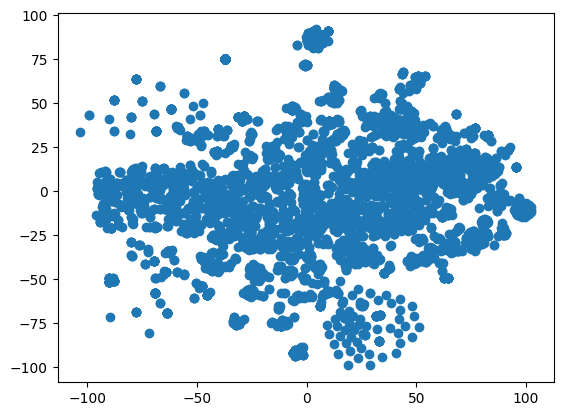

In [ ]:
tweets = []
for row in result_df.itertuples(index=True):
    tweets.append(str(row.Tweet))

# represent the word as a vector
words = [tweet.split() for tweet in tweets]

model = Word2Vec(sentences=words, workers=2, window=3, min_count=200)
# Words appearing fewer than 200 times are ignored, and a context window of 3 words before and after the target word is considered.
# Change the hyperparams, window and min_count in order to obtain more meaningful results.

# the tweet, i.e., resulted as the average value over the words involved
tweet_vectors = []
for tweet in words:
    word_vectors = [model.wv[word] for word in tweet if word in model.wv]
    if word_vectors:
        tweet_vector = sum(word_vectors) / len(word_vectors)
        tweet_vectors.append(tweet_vector)
    else:
        tweet_vectors.append(np.zeros(model.vector_size))

tweet_vectors = np.array(tweet_vectors)

algorithm_tsne = TSNE(n_components=2)                       # represent the tweets in a two-dimensional scatter plot through the T-SNE
tweet_vectors_tsne = algorithm_tsne.fit_transform(tweet_vectors)

plt.scatter(tweet_vectors_tsne[:, 0], tweet_vectors_tsne[:, 1])
plt.show()